# Makine Öğrenmesi ile Yetenek Avcılığı Sınıflandırma

## İş Problemi

Scout’lar tarafından izlenen futbolcuların özelliklerine verilen puanlara göre, oyuncuların hangi sınıf (average, highlighted) oyuncu olduğunu tahminleme.

## Veri Seti Hikayesi

Veri seti Scoutium’dan maçlarda gözlemlenen futbolcuların özelliklerine göre scoutların değerlendirdikleri futbolcuların, maç içerisinde puanlanan özellikleri ve puanlarını içeren bilgilerden oluşmaktadır.

## Değişkenler

**scoutium_attributes.csv**
* **task_response_id:** Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi
* **match_id:** İlgili maçın id'si
* **evaluator_id:** Değerlendiricinin(scout'un) id'si
* **player_id:** İlgili oyuncunun id'si
* **position_id:** İlgili oyuncunun o maçta oynadığı pozisyonun id’si 
        - 1: Kaleci
        - 2: Stoper
        - 3: Sağ bek
        - 4: Sol bek
        - 5: Defansif orta saha 
        - 6: Merkez orta saha 
        - 7: Sağ kanat
        - 8: Sol kanat
        - 9: Ofansif orta saha 
        - 10: Forvet
* **analysis_id:** Bir scoutun bir maçta bir oyuncuya dair özellik değerlendirmelerini içeren küme
* **attribute_id:** Oyuncuların değerlendirildiği her bir özelliğin id'si
* **attribute_value:** Bir scoutun bir oyuncunun bir özelliğine verdiği değer(puan)

**scoutium_potential_labels.csv**

* **task_response_id:** Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi
* **match_id:** İlgili maçın id'si
* **evaluator_id:** Değerlendiricinin(scout'un) id'si
* **player_id:** İlgili oyuncunun id'si
* **potential_label:** Bir scoutun bir maçta bir oyuncuyla ilgili nihai kararını belirten etiket. (hedef değişken)

In [1]:
# Adım 1: scoutium_attributes.csv ve scoutium_potential_labels.csv dosyalarını okutunuz.

# Gerekli kütüphanelerin yüklenmesi
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
att_data = pd.read_csv('/Users/melihgunaydin/Desktop/Miuul DSML16/6- Machine Learning/Machine Learning 3. Hafta/Scoutium-220805-075951/scoutium_attributes.csv', sep=";")
potential_data = pd.read_csv('/Users/melihgunaydin/Desktop/Miuul DSML16/6- Machine Learning/Machine Learning 3. Hafta/Scoutium-220805-075951/scoutium_potential_labels.csv', sep=";")

In [3]:
# Adım 2: Okutmuş olduğumuz csv dosyalarını merge fonksiyonunu kullanarak birleştiriniz.

# Verileri birleştir
df = pd.merge(att_data, potential_data,
                        on=['task_response_id', 'match_id', 'evaluator_id', 'player_id'],
                        how='inner')  # veya 'outer', 'left', 'right' ihtiyacınıza göre

In [4]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [5]:
df.shape

(10730, 9)

In [6]:
# Adım 3: position_id içerisindeki Kaleci (1) sınıfını veri setinden kaldırınız.
df = df[df["position_id"] != 1]

In [7]:
df.position_id.value_counts()

2     1972
6     1428
10    1088
8     1020
7      986
3      986
4      884
9      850
5      816
Name: position_id, dtype: int64

In [8]:
df.shape

(10030, 9)

In [9]:
# Adım 4: potential_label içerisindeki below_average sınıfını veri setinden kaldırınız.( below_average sınıfı tüm verisetinin %1'ini oluşturur)
df = df[df["potential_label"] != "below_average"]

In [10]:
df["attribute_id"].value_counts()

4322    291
4353    291
4345    291
4348    291
4349    291
4350    291
4351    291
4352    291
4354    291
4323    291
4355    291
4356    291
4357    291
4407    291
4408    291
4423    291
4344    291
4343    291
4342    291
4341    291
4340    291
4339    291
4338    291
4335    291
4333    291
4332    291
4330    291
4329    291
4328    291
4327    291
4326    291
4325    291
4324    291
4426    291
Name: attribute_id, dtype: int64

In [11]:
df.shape

(9894, 9)

In [12]:
# Adım 5: Oluşturduğunuz veri setinden “pivot_table” fonksiyonunu kullanarak bir tablo oluşturunuz. Bu pivot table'da her satırda bir oyuncu olacak şekilde manipülasyon yapınız.

# Adım 5.1: indekste “player_id”,“position_id” ve “potential_label”, sütunlarda “attribute_id” ve değerlerde scout’ların oyunculara verdiği puan “attribute_value” olacak şekilde pivot table’ı oluşturunuz.
df.isnull().sum()

task_response_id    0
match_id            0
evaluator_id        0
player_id           0
position_id         0
analysis_id         0
attribute_id        0
attribute_value     0
potential_label     0
dtype: int64

In [13]:
df = df.pivot_table(index= ["player_id", "position_id", "potential_label"], columns='attribute_id', values="attribute_value")

In [14]:
df.head()

attribute_id                           4322  4323  4324  4325  4326  4327  4328  4329  4330  4332  4333  4335  4338  4339  4340  4341  4342  4343  4344  4345  4348  4349  4350  4351  4352  4353  4354  4355  4356  4357  4407  4408  4423  4426
player_id position_id potential_label                                                                                                                                                                                                            
1355710   7           average          50.5  50.5  34.0  50.5  45.0  45.0  45.0  45.0  50.5  56.0  39.5  34.0  39.5  39.5  45.0  45.0  50.5  28.5  23.0  39.5  28.5  28.5  45.0  50.5  56.0  34.0  39.5  50.5  34.0  34.0  56.0  34.0  34.0  56.0
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  56.0  67.0  67.0  56.0  67.0  67.0  67.0  67.0  78.0  67.0  67.0  67.0  67.0  67.0  56.0  78.0
1356375   3           average          67.0  67.0  67.0  67.0  67.0  67.0  67.0  78.0  67.0  67.0  78.0  56.0  67.0  67.0  67.0  67.0  67.0  56.0  56.0  67.0  67.0  56.0  56.0  67.0  67.0  67.0  78.0  67.0  67.0  67.0  67.0  67.0  56.0  78.0
          4           average          67.0  78.0  67.0  67.0  67.0  78.0  78.0  78.0  56.0  67.0  67.0  67.0  78.0  78.0  56.0  67.0  67.0  45.0  45.0  56.0  67.0  67.0  67.0  67.0  78.0  67.0  67.0  67.0  56.0  67.0  56.0  67.0  45.0  56.0
1356411   9           average          67.0  67.0  78.0  78.0  67.0  67.0  67.0  67.0  89.0  78.0  67.0  67.0  67.0  56.0  56.0  67.0  78.0  56.0  56.0  67.0  56.0  67.0  56.0  67.0  67.0  56.0  67.0  67.0  56.0  67.0  89.0  56.0  67.0  78.0

In [15]:
# Adım 5.2: “reset_index” fonksiyonunu kullanarak indeksleri değişken olarak atayınız ve “attribute_id” sütunlarının isimlerini stringe çeviriniz.
df = df.reset_index()

In [16]:
df.columns = df.columns.map(str)

In [17]:
df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,45.0,50.5,56.0,39.5,34.0,39.5,39.5,45.0,45.0,50.5,28.5,23.0,39.5,28.5,28.5,45.0,50.5,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,56.0,56.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,78.0,56.0,67.0,67.0,67.0,78.0,78.0,56.0,67.0,67.0,45.0,45.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,67.0,89.0,78.0,67.0,67.0,67.0,56.0,56.0,67.0,78.0,56.0,56.0,67.0,56.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


In [18]:
df[df["4322"] > 80]

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
24,1361221,2,highlighted,89.0,78.0,67.0,56.0,78.0,67.0,56.0,56.0,56.0,56.0,67.0,56.0,67.0,78.0,34.0,45.0,56.0,34.0,23.0,56.0,89.0,34.0,78.0,100.0,67.0,78.0,67.0,67.0,56.0,78.0,45.0,78.0,56.0,45.0


In [19]:
# Adım6: LabelEncoder fonksiyonunu kullanarak “potential_label” kategorilerini(average,highlighted)sayısal olarak ifade ediniz.

# Label Encoding işlemi
df["potential_label"].value_counts()

average        215
highlighted     56
Name: potential_label, dtype: int64

In [20]:
le = LabelEncoder()
df['potential_label'] = le.fit_transform(df['potential_label'])

In [21]:
df["potential_label"].value_counts()

0    215
1     56
Name: potential_label, dtype: int64

In [22]:
# Adım 7: Sayısal değişken kolonlarını “num_cols” adıyla bir listeye atayınız.
num_cols = [col for col in df.columns if "player_id" not in col and "potential_label" not in col]

In [23]:
num_cols

['position_id',
 '4322',
 '4323',
 '4324',
 '4325',
 '4326',
 '4327',
 '4328',
 '4329',
 '4330',
 '4332',
 '4333',
 '4335',
 '4338',
 '4339',
 '4340',
 '4341',
 '4342',
 '4343',
 '4344',
 '4345',
 '4348',
 '4349',
 '4350',
 '4351',
 '4352',
 '4353',
 '4354',
 '4355',
 '4356',
 '4357',
 '4407',
 '4408',
 '4423',
 '4426']

In [24]:
# Adım 8: Kaydettiğiniz bütün “num_cols” değişkenlerindeki veriyi ölçeklendirmek için StandardScaler uygulayınız.
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [25]:
df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,0.511290,0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,-0.791605,-0.446324,-0.122619,-1.223858,-1.035633,-1.126240,-1.009285,-0.541797,-0.690375,-0.535091,-1.067288,-1.205671,-1.004927,-1.313773,-1.041775,-0.693269,-0.435633,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,1356362,1.256234,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,0.404075,0.727985,0.691171,0.459154,0.996474,0.631888,0.840464,0.911936,0.799406,0.588047,1.229965,0.749536,0.742305,0.878802,0.669953,0.847750,0.716763,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,1356375,-0.978598,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,1.001915,0.727985,0.691171,1.132359,0.319105,0.631888,0.840464,0.911936,0.799406,0.588047,0.573607,0.749536,0.742305,0.878802,0.669953,0.077240,0.716763,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,1356375,-0.606126,0,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,1.001915,-0.054888,0.691171,0.459154,0.996474,1.335139,1.580363,0.185069,0.799406,0.588047,-0.082751,0.097800,0.043412,0.878802,1.354645,0.847750,0.716763,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,1356411,1.256234,0,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,0.404075,2.293730,1.504961,0.459154,0.996474,0.631888,0.100564,0.185069,0.799406,1.336806,0.573607,0.749536,0.742305,0.252352,1.354645,0.077240,0.716763,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611


In [26]:
# Adım 9: Elimizdeki veri seti üzerinden minimum hata ile futbolcuların potansiyel etiketlerini tahmin eden bir makine öğrenmesi modeli geliştiriniz. (Roc_auc, f1, precision, recall, accuracy metriklerini yazdırınız.)
y = df["potential_label"]
X = df[num_cols]

log_model = LogisticRegression().fit(X, y)

In [27]:
log_model.intercept_

array([-2.18824415])

In [28]:
log_model.coef_

array([[-0.20591571,  0.17530026,  0.0455339 , -0.12497523,  1.9945156 ,
         0.90406835, -0.69250273, -0.55000711,  0.03216059, -0.04303945,
        -0.52292349, -0.72634442, -0.02681738, -0.06333988,  0.5600584 ,
        -0.38105504,  0.55216279,  0.13648318,  0.3115388 ,  0.68858548,
         0.37063877,  0.22157773, -1.15849969,  0.10853137,  0.30836583,
         0.12385469,  1.20281013, -0.72352819,  0.30047786, -0.63550195,
        -0.38656717,  1.0194175 , -0.22778065, -0.41651351, -1.27231978]])

In [29]:
y_pred = log_model.predict(X)

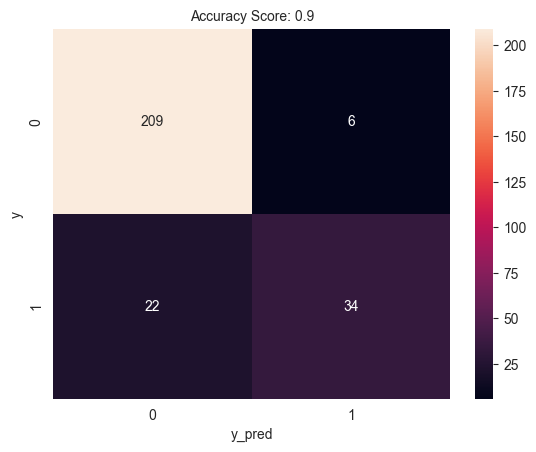

In [30]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

In [31]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       215
           1       0.85      0.61      0.71        56

    accuracy                           0.90       271
   macro avg       0.88      0.79      0.82       271
weighted avg       0.89      0.90      0.89       271


In [32]:
# ROC AUC
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.9187707641196013

In [33]:
# Model Validation: Holdout
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

log_model = LogisticRegression().fit(X_train, y_train)

In [34]:
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89        41
           1       0.83      0.36      0.50        14

    accuracy                           0.82        55
   macro avg       0.82      0.67      0.69        55
weighted avg       0.82      0.82      0.79        55


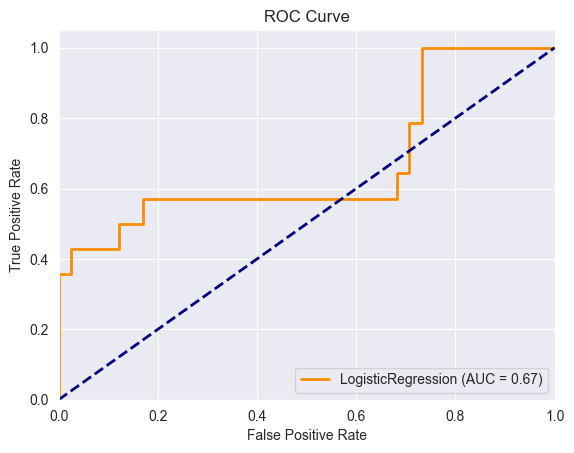

In [35]:
# ROC eğrisini hesapla
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çiz
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='LogisticRegression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [36]:
# Model Validation: 10-Fold Cross Validation
y = df["potential_label"]
X = df[num_cols]

log_model = LogisticRegression().fit(X, y)

cv_results = cross_validate(log_model,
                            X, y,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [37]:
cv_results['test_accuracy'].mean()

0.8525132275132276

In [38]:
cv_results['test_precision'].mean()

0.7738095238095238

In [39]:
cv_results['test_recall'].mean()

0.49000000000000005

In [40]:
cv_results['test_f1'].mean()

0.5684648684648684

In [41]:
cv_results['test_roc_auc'].mean()

0.846082251082251

In [42]:
last_df = pd.DataFrame({
    "player_id": df["player_id"],
    "real_value": df["potential_label"],
    "predict": log_model.predict(X)
})

In [43]:
last_df.head(20)

,player_id,real_value,predict
0,1355710,0,0
1,1356362,0,0
2,1356375,0,0
3,1356375,0,0
4,1356411,0,0
5,1356411,0,0
6,1358222,0,0
7,1358274,1,1
8,1359349,1,0
9,1359355,0,0


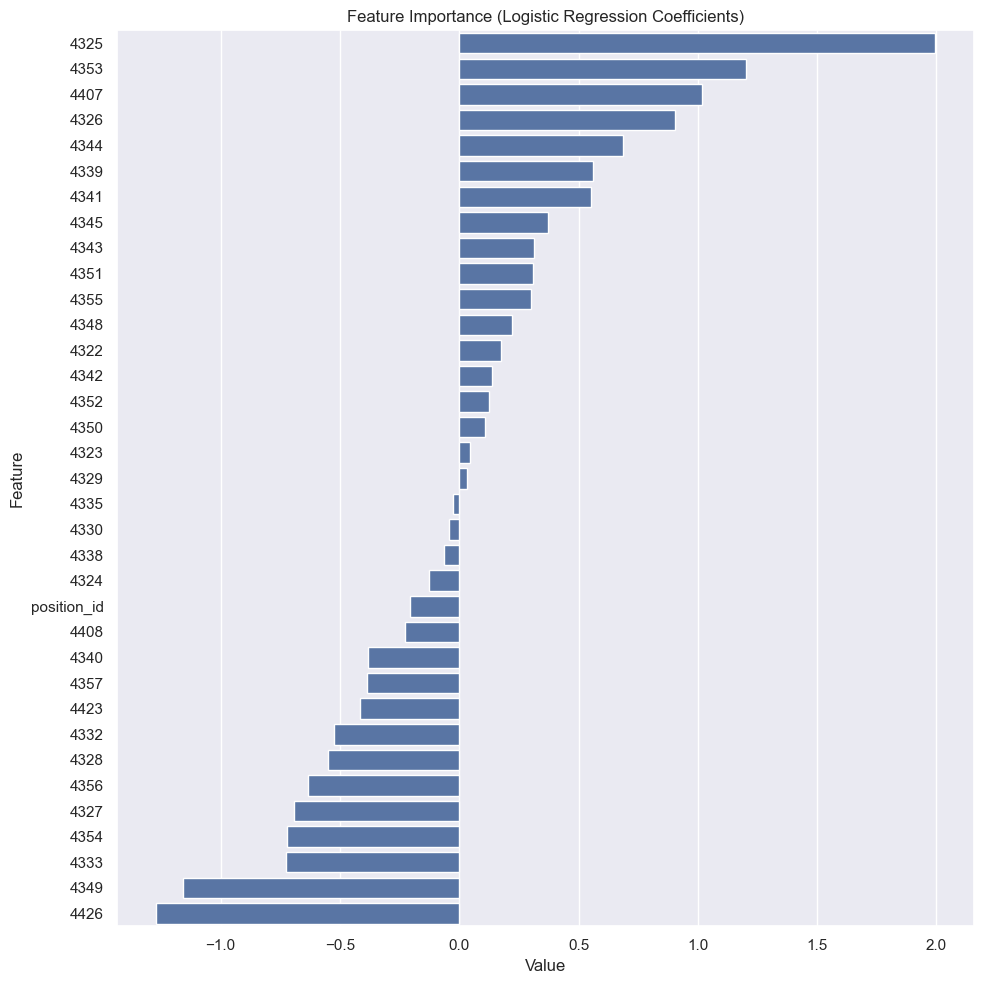

In [48]:
# Adım 10: Değişkenlerin önem düzeyini belirten feature_importance fonksiyonunu kullanarak özelliklerin sıralamasını çizdiriniz.
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.coef_[0], 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Feature Importance (Logistic Regression Coefficients)')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(log_model, X_train)